In [45]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# PRACTICE 2 
RECOMMENDER SYSTEM 



> ERGUN Emrullah






This practice aim to train us to create a recommender system. 
The goal is defined as follows:


1.   Construct a recommender system for the given dataset 
2.   Try all the metrics you can and recommender system concepts

We will, in order to fulfill our goals try three types of recommenders systems:
Broadly, recommender systems can be classified into 3 types:

* Simple recommenders: offer generalized recommendations to every user, 
based on movie popularity and/or genre. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience. IMDB Top 250 is an example of this system.

* Content-based recommenders: suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.

* Collaborative filtering engines: these systems try to predict the rating or preference that a user would give an item-based on past ratings and preferences of other users. Collaborative filters do not require item metadata like its content-based counterparts.

The dataset concentrate a large number of books. It contains six million ratings for ten thousand most popular (with most ratings) books. There are also:

1. books marked to read by the users
2. book metadata (author, year, etc.)
3. tags/shelves/genres

# 1 . Loading datasets and libraries

In [46]:
%matplotlib inline

import pandas as pd

rating = pd.read_csv( '/content/gdrive/MyDrive/UPM_ALUMNOS_2021/LSMA/RECOMMENDER SYSTEMS/Practice_3_Recommenders/goodbooks-10k-master/ratings.csv' )
tr = pd.read_csv( '/content/gdrive/MyDrive/UPM_ALUMNOS_2021/LSMA/RECOMMENDER SYSTEMS/Practice_3_Recommenders/goodbooks-10k-master/to_read.csv' )
b = pd.read_csv( '/content/gdrive/MyDrive/UPM_ALUMNOS_2021/LSMA/RECOMMENDER SYSTEMS/Practice_3_Recommenders/goodbooks-10k-master/books.csv' )

t = pd.read_csv( '/content/gdrive/MyDrive/UPM_ALUMNOS_2021/LSMA/RECOMMENDER SYSTEMS/Practice_3_Recommenders/goodbooks-10k-master/tags.csv' )
bt = pd.read_csv( '/content/gdrive/MyDrive/UPM_ALUMNOS_2021/LSMA/RECOMMENDER SYSTEMS/Practice_3_Recommenders/goodbooks-10k-master/book_tags.csv')

Loading useful libraries

In [47]:
import numpy as np

##  Exploratory Data Analyse 



1. Ratings



In [48]:
rating.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [49]:
print("There is " ,str(len(rating['user_id'].unique())) , "Different Users")

There is  53424 Different Users


In [50]:
len(rating['book_id'].unique())

10000

10000 books are reviewed

In [51]:
reviews_per_book = rating.groupby( 'book_id' ).book_id.apply( lambda x: len( x )).reset_index(name = 'nb_rating')
reviews_per_book['nb_rating'].describe()

count    10000.000000
mean       597.647900
std       1267.289788
min          8.000000
25%        155.000000
50%        248.000000
75%        503.000000
max      22806.000000
Name: nb_rating, dtype: float64

In [52]:
reviews_per_book.head()

,book_id,nb_rating
0,1,22806
1,2,21850
2,3,16931
3,4,19088
4,5,16604


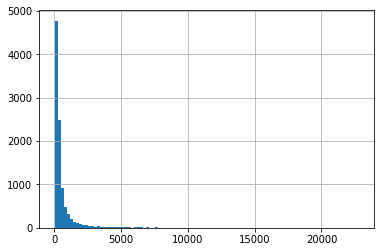

In [53]:
reviews_per_book.nb_rating.hist( bins = 100)

In [54]:
reviews_per_users = rating.groupby( 'user_id' ).user_id.apply( lambda x: len( x )).reset_index(name = 'nb_review')
reviews_per_users.describe()

,user_id,nb_review
count,53424.000000,53424.000000
mean,26712.500000,111.868804
std,15422.324727,26.071224
min,1.000000,19.000000
25%,13356.750000,96.000000
50%,26712.500000,111.000000
75%,40068.250000,128.000000
max,53424.000000,200.000000


In [55]:
rating_per_book = rating.groupby( ['book_id'] ).rating.mean().reset_index(name = 'rating')
rating_per_book.describe()

,book_id,rating
count,10000.00000,10000.000000
mean,5000.50000,3.903136
std,2886.89568,0.285346
min,1.00000,2.077966
25%,2500.75000,3.728160
50%,5000.50000,3.922021
75%,7500.25000,4.097793
max,10000.00000,4.829876


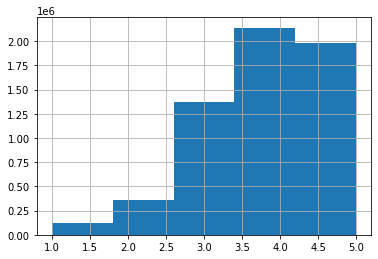

In [56]:
rating.rating.hist( bins = 5 )

All books got ratings and that is a good point. But there is one book who has only 8 ratings, that can be problematic later.
We can see that most of the ratings given by one user are between 3 and 5. The mean number of review for a user is 19, this is really encouraging.
Finally the mean ratings for all the books is 3.9 with a min at 2 and a max at 4.8. 


### 2. To read 



In [57]:
tr.head(10)

,user_id,book_id
0,9,8
1,15,398
2,15,275
3,37,7173
4,34,380
5,34,483
6,34,8598
7,34,3581
8,70,498
9,76,4250


In [58]:
tr['user_id'].count()

912705

In [59]:
books_to_read_per_users = tr.groupby(['user_id']).book_id.count()
books_to_read_per_users.head()

user_id
1     7
2    32
3    13
5     4
6    13
Name: book_id, dtype: int64

In [60]:
books_to_read_per_users.describe()

count    48871.000000
mean        18.675800
std         16.089767
min          1.000000
25%          6.000000
50%         14.000000
75%         27.000000
max        117.000000
Name: book_id, dtype: float64


48871 Users have a book they want to read on our pool of 53424, thats is good.

### 3. Books 

In [61]:
b.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [62]:
b['average_rating'].mean()

4.002191000000001

### 4. Tags

In [63]:
t.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


There is nothing really interresting here. As we should merge it with the table book tags, see below.

### 5. Book tags

In [64]:
bt.head(10)

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716
5,1,11743,9954
6,1,14017,7169
7,1,5207,6221
8,1,22743,4974
9,1,32989,4364


In [65]:
bt_new = bt.merge( t, on = 'tag_id' )
bt_new.head()

,goodreads_book_id,tag_id,count,tag_name
0,1,30574,167697,to-read
1,2,30574,24549,to-read
2,3,30574,496107,to-read
3,5,30574,11909,to-read
4,6,30574,298,to-read


In [66]:
bt_new = bt_new.merge( b[['goodreads_book_id', 'book_id', 'title']], on = 'goodreads_book_id' )
bt_new.head()

,goodreads_book_id,tag_id,count,tag_name,book_id,title
0,1,30574,167697,to-read,27,Harry Potter and the Half-Blood Prince (Harry ...
1,1,11305,37174,fantasy,27,Harry Potter and the Half-Blood Prince (Harry ...
2,1,11557,34173,favorites,27,Harry Potter and the Half-Blood Prince (Harry ...
3,1,8717,12986,currently-reading,27,Harry Potter and the Half-Blood Prince (Harry ...
4,1,33114,12716,young-adult,27,Harry Potter and the Half-Blood Prince (Harry ...


In [67]:
bt_new['count'].describe()

count    999912.000000
mean        208.869633
std        3501.265173
min          -1.000000
25%           7.000000
50%          15.000000
75%          40.000000
max      596234.000000
Name: count, dtype: float64

In [68]:
bt_new.loc[ bt_new['count'] < 0, 'count'] = 0

In [69]:
bt_new.loc[ bt_new['count'] == 0, 'title']

920799    Kindle Paperwhite User's Guide
920815    Kindle Paperwhite User's Guide
920823    Kindle Paperwhite User's Guide
920854    Kindle Paperwhite User's Guide
920855    Kindle Paperwhite User's Guide
958159               Kindle User's Guide
Name: title, dtype: object

We have merged tags name and books names with the book tag table, like this it is easier to see the tags of a book. We saw that some tag count's where negative, we set them to 0. We can see that they are all related to the Kindle's user guide. 

In [70]:
tag_counts = bt_new.groupby( 'tag_name' ).tag_name.count().sort_values( ascending = False )
tag_counts.head( 30 )

tag_name
to-read              9983
favorites            9881
owned                9858
books-i-own          9799
currently-reading    9776
library              9415
owned-books          9221
fiction              9097
to-buy               8692
kindle               8316
default              8239
ebook                8054
my-books             7561
audiobook            7242
ebooks               7203
wish-list            7192
my-library           7000
audiobooks           6862
i-own                6670
adult                6604
audio                6548
favourites           6422
novels               5665
own-it               5514
contemporary         5287
read-in-2015         5239
series               5080
e-book               4941
read-in-2016         4940
read-in-2014         4902
Name: tag_name, dtype: int64

# 2. Simple methods recomender

I will make a simple recommender using the Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$ formula. 

where,

- v is the number of votes for the book;
- m is the minimum votes required to be listed in the chart;
- R is the average rating of the book; 
- C is the mean vote across the whole report;

In [73]:
# Calculate C
C = rating_per_book['rating'].mean()
print(C)

3.903135936008679


The mean rating for a book is of 3.9/5

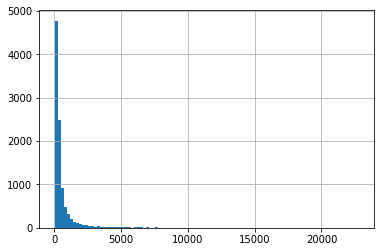

In [74]:
reviews_per_book.nb_rating.hist( bins = 100)

Most of the books have less than 2500 ratings. Hence we can use a m that is pretty low. 

In [75]:
# Calculate the minimum number of votes required to be in the chart, m
m = reviews_per_book['nb_rating'].quantile(0.30)
print(m)

170.0


In [76]:
#We merge the dataframe with the rating and the dataframe with the number of rating. And let's also add the title
reviews_rating_per_book = reviews_per_book.merge(rating_per_book, on = 'book_id')
reviews_rating_per_book = reviews_rating_per_book.merge( b[['book_id','title']], on = 'book_id')
reviews_rating_per_book.head()

,book_id,nb_rating,rating,title
0,1,22806,4.279707,"The Hunger Games (The Hunger Games, #1)"
1,2,21850,4.351350,Harry Potter and the Sorcerer's Stone (Harry P...
2,3,16931,3.214341,"Twilight (Twilight, #1)"
3,4,19088,4.329369,To Kill a Mockingbird
4,5,16604,3.772224,The Great Gatsby


In [77]:
# Filter out all qualified books into a new DataFrame
new_reviews_rating_per_book = reviews_rating_per_book.copy().loc[reviews_rating_per_book['nb_rating'] >= m]
new_reviews_rating_per_book.shape

(7006, 4)

We have 7006 books that qualify. Now we will define our weighted metric function. 

In [78]:
# Function that computes the weighted rating of each book
def weighted_rating(x, m=m, C=C):
    v = x['nb_rating']
    R = x['rating']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [79]:
#We apply the function on our Dataframe and add the score in a new column
new_reviews_rating_per_book['score'] = new_reviews_rating_per_book.apply(weighted_rating, axis=1)
new_reviews_rating_per_book.head()

,book_id,nb_rating,rating,title,score
0,1,22806,4.279707,"The Hunger Games (The Hunger Games, #1)",4.276921
1,2,21850,4.351350,Harry Potter and the Sorcerer's Stone (Harry P...,4.347890
2,3,16931,3.214341,"Twilight (Twilight, #1)",3.221188
3,4,19088,4.329369,To Kill a Mockingbird,4.325607
4,5,16604,3.772224,The Great Gatsby,3.773550


In [80]:
new_reviews_rating_per_book = new_reviews_rating_per_book.sort_values('score', ascending=False)
new_reviews_rating_per_book.head(50)

,book_id,nb_rating,rating,title,score
861,862,1373,4.702840,"Words of Radiance (The Stormlight Archive, #2)",4.614733
421,422,1915,4.659530,"Harry Potter Boxset (Harry Potter, #1-7)",4.597858
1307,1308,933,4.718114,A Court of Mist and Fury (A Court of Thorns an...,4.592505
3627,3628,482,4.829876,The Complete Calvin and Hobbes,4.588241
779,780,1394,4.661406,Calvin and Hobbes,4.578985
1009,1010,1249,4.652522,The Essential Calvin and Hobbes: A Calvin and ...,4.562744
1787,1788,652,4.728528,The Calvin and Hobbes Tenth Anniversary Book,4.557826
24,25,15304,4.525941,Harry Potter and the Deathly Hallows (Harry Po...,4.519099
561,562,1789,4.545556,"The Way of Kings (The Stormlight Archive, #1)",4.489808
4482,4483,384,4.747396,It's a Magical World: A Calvin and Hobbes Coll...,4.488327


And here we have the 50 best books !

# 3. Content Base Recomender 

## 1. Try to have one big tag string for every book

In [81]:
bt_new.head()

,goodreads_book_id,tag_id,count,tag_name,book_id,title
0,1,30574,167697,to-read,27,Harry Potter and the Half-Blood Prince (Harry ...
1,1,11305,37174,fantasy,27,Harry Potter and the Half-Blood Prince (Harry ...
2,1,11557,34173,favorites,27,Harry Potter and the Half-Blood Prince (Harry ...
3,1,8717,12986,currently-reading,27,Harry Potter and the Half-Blood Prince (Harry ...
4,1,33114,12716,young-adult,27,Harry Potter and the Half-Blood Prince (Harry ...


In [82]:
book_tag = bt_new.groupby(['book_id','title'])['tag_name'].apply( lambda x :  ' '.join(x)).reset_index(name="Full_tag")
book_tag.head()

,book_id,title,Full_tag
0,1,"The Hunger Games (The Hunger Games, #1)",to-read fantasy favorites currently-reading yo...
1,2,Harry Potter and the Sorcerer's Stone (Harry P...,to-read fantasy favorites currently-reading yo...
2,3,"Twilight (Twilight, #1)",to-read fantasy favorites currently-reading yo...
3,4,To Kill a Mockingbird,to-read favorites currently-reading young-adul...
4,5,The Great Gatsby,to-read favorites currently-reading young-adul...


Now that we have the tags we will compute the word vectors of each tag or document, as it will be called from now on.

In [83]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
book_tag['Full_tag'] = book_tag['Full_tag'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(book_tag['Full_tag'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(10000, 16396)



We could have supressed customized tags but I considered here that similar book would have the same customized labels, especially thoose with a high rating

We can see that 16396 words where used to describe our 10000 books, the ratio book/words is way bigger than the one we had during the lab with the movies.

In [84]:
#Reverse mapping to find the indices of a book from it's title
indices = pd.Series(book_tag.index, index=book_tag['title']).drop_duplicates()

In [85]:
from sklearn.metrics.pairwise import linear_kernel

# Function that takes in book title as input and outputs most similar books
def get_recommendations(title, tfidf_matrix):
    # Get the index of the book that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all books with that book
    cosine_sim = linear_kernel(tfidf_matrix[idx,:], tfidf_matrix)
    sim_scores = list(enumerate(cosine_sim[0]))

    # Sort the books based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar books
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    book_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar books
    return book_tag['title'].iloc[book_indices]

In [133]:
get_recommendations('The Hunger Games (The Hunger Games, #1)', tfidf_matrix)

16                   Catching Fire (The Hunger Games, #2)
19                      Mockingjay (The Hunger Games, #3)
506     The Hunger Games Trilogy Boxset (The Hunger Ga...
11                              Divergent (Divergent, #1)
279                               Delirium (Delirium, #1)
2562                  Monsters of Men (Chaos Walking, #3)
2300           The Ask and the Answer (Chaos Walking, #2)
780                                 Specials (Uglies, #3)
326                                   Legend (Legend, #1)
68                              Insurgent (Divergent, #2)
Name: title, dtype: object

In [134]:
new_reviews_rating_per_book.loc[new_reviews_rating_per_book['rating']<3 , ['title','rating'] ]

,title,rating
6393,The Fever,2.911330
6473,Seating Arrangements,2.942387
5889,"The Prophet of Yonwood (Book of Ember, #3)",2.910714
3876,Girls in White Dresses,2.937908
2242,The Good Neighbor,2.981675
9020,Lost,2.618090
4613,The Emperor's Children,2.793333
4281,Pygmy,2.780645
3145,Adultery,2.634921
1821,"Revolution 2020: Love, Corruption, Ambition",2.492537


In [136]:
get_recommendations('The Mermaid Chair', tfidf_matrix)

9662              Ya Yas in Bloom
2687             The Peach Keeper
56        The Secret Life of Bees
6578              Gods in Alabama
3183              The Sugar Queen
436        The Invention of Wings
2938                  Beach Music
7707    A Grown-Up Kind of Pretty
9169             Between, Georgia
1184              Cold Sassy Tree
Name: title, dtype: object

Honestly I dont read so much books but i went on the internet to check them on amazon and surpisingly some of my recommendations appears in amazon. I like to think that our recommendation are pretty good !

# 4. A collaborative filtering recommender

## 1. Loading and parsing datasets

No we are ready to read in each of the files and create an RDD consisting of parsed lines.



In [89]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q ftp://mirror.klaus-uwe.me/apache/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz

In [90]:
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

In [91]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

So let's load the raw ratings data. We need to filter out the header, included in each file.

We will change the CSV rating so the rating is a float and not a string. Otherwhise it cause problems with the ALS algorithm

In [92]:
rating = rating.astype({"rating": float})
rating.head()

,user_id,book_id,rating
0,1,258,5.0
1,2,4081,4.0
2,2,260,5.0
3,2,9296,5.0
4,2,2318,3.0


In [94]:
rating.to_csv('/content/gdrive/MyDrive/UPM_ALUMNOS_2021/LSMA/RECOMMENDER SYSTEMS/Practice_3_Recommenders/goodbooks-10k-master/r2.csv', index = False)
r2 = pd.read_csv('/content/gdrive/MyDrive/UPM_ALUMNOS_2021/LSMA/RECOMMENDER SYSTEMS/Practice_3_Recommenders/goodbooks-10k-master/r2.csv')
r2.head()

,user_id,book_id,rating
0,1,258,5.0
1,2,4081,4.0
2,2,260,5.0
3,2,9296,5.0
4,2,2318,3.0


In [101]:
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf

sc = SparkContext.getOrCreate()

ratings_file = os.path.join('/content/gdrive/MyDrive/UPM_ALUMNOS_2021/LSMA/RECOMMENDER SYSTEMS/Practice_3_Recommenders/goodbooks-10k-master' , 'r2.csv')

ratings_raw_data = sc.textFile(ratings_file)
ratings_raw_data_header = ratings_raw_data.take(1)[0]

In [102]:
ratings_raw_data.take(1)

['user_id,book_id,rating']

Now we can parse the raw data into a new RDD.



In [103]:
ratings_data = ratings_raw_data.filter(lambda line: line!=ratings_raw_data_header)\
  .map(lambda line: line.split(",")).map(lambda tokens: (tokens[0],tokens[1],tokens[2])).cache()

In [104]:
ratings_data.take(3)

[('1', '258', '5.0'), ('2', '4081', '4.0'), ('2', '260', '5.0')]

In [105]:
type(ratings_data.take(1))

list

We do the same thing for the `books.csv` file

We do a new CSV file with just the books ID and the Name because I had problems with the titles not being all between ' ' symbols. 

In [106]:
b = b[['book_id','title']]
b.head()
b.to_csv('/content/gdrive/MyDrive/UPM_ALUMNOS_2021/LSMA/RECOMMENDER SYSTEMS/Practice_3_Recommenders/goodbooks-10k-master/books2.csv', index = False)

In [107]:
books2 = pd.read_csv('/content/gdrive/MyDrive/UPM_ALUMNOS_2021/LSMA/RECOMMENDER SYSTEMS/Practice_3_Recommenders/goodbooks-10k-master/books2.csv')
books2.head()

,book_id,title
0,1,"The Hunger Games (The Hunger Games, #1)"
1,2,Harry Potter and the Sorcerer's Stone (Harry P...
2,3,"Twilight (Twilight, #1)"
3,4,To Kill a Mockingbird
4,5,The Great Gatsby


In [108]:
books_file = os.path.join('/content/gdrive/MyDrive/UPM_ALUMNOS_2021/LSMA/RECOMMENDER SYSTEMS/Practice_3_Recommenders/goodbooks-10k-master' , 'books2.csv')

books_raw_data = sc.textFile(books_file)

books_raw_data_header = books_raw_data.take(1)[0]

books_data = books_raw_data.filter(lambda line: line!=books_raw_data_header)\
  .map(lambda line: line.split(',')).map(lambda tokens: (tokens[0],tokens[1])).cache()

books_data.take(8)

[('1', '"The Hunger Games (The Hunger Games'),
 ('2', '"Harry Potter and the Sorcerer\'s Stone (Harry Potter'),
 ('3', '"Twilight (Twilight'),
 ('4', 'To Kill a Mockingbird'),
 ('5', 'The Great Gatsby'),
 ('6', 'The Fault in Our Stars'),
 ('7', 'The Hobbit'),
 ('8', 'The Catcher in the Rye')]

## 2. Selecting the alternating Least Square Parameters

We split the data into train, validation and test.

In [109]:
training_RDD, validation_RDD, test_RDD = ratings_data.randomSplit([6, 2, 2], seed=0)
validation_for_predict_RDD = validation_RDD.map(lambda x: (x[0], x[1]))
test_for_predict_RDD = test_RDD.map(lambda x: (x[0], x[1]))

In [110]:
training_RDD.take(1)

[('1', '258', '5.0')]

Now we can proceed with the training phase. 

I try for 4 different rank to have the best model possible

In [111]:
from pyspark.mllib.recommendation import ALS
import math

seed = 5
iterations = 10
regularization_parameter = 0.1
ranks = [4, 8, 12, 20]
errors = [0, 0, 0, 0]
err = 0
tolerance = 0.02

min_error = float('inf')
best_rank = -1
best_iteration = -1
for rank in ranks:
    model = ALS.train(training_RDD, rank, seed=seed, iterations=iterations, lambda_=regularization_parameter)
    predictions = model.predictAll(validation_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
    rates_and_preds = validation_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
    error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    errors[err] = error
    err += 1
    print('For rank %s the RMSE is %s' % (rank, error))
    if error < min_error:
        min_error = error
        best_rank = rank

print('The best model was trained with rank %s' % best_rank)

For rank 4 the RMSE is 0.8354914853035305
For rank 8 the RMSE is 0.8280207082238561
For rank 12 the RMSE is 0.8254628865127762
For rank 20 the RMSE is 0.8276197424008557
The best model was trained with rank 12


In [112]:
predictions.take(3)

[((41234, 148), 3.5557450823963146),
 ((41234, 9864), 4.089118107781834),
 ((41234, 178), 3.9678617984343907)]

In [113]:
rates_and_preds.take(3)

[((4, 27), (5.0, 4.141817421252146)),
 ((4, 145), (2.0, 2.8794172901747164)),
 ((4, 86), (4.0, 3.540400028258471))]

Now we test our model 

In [114]:
model = ALS.train(training_RDD, best_rank, seed=seed, iterations=iterations, lambda_=regularization_parameter)
predictions = model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
rates_and_preds = test_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    
print('For testing data the RMSE is %s' % (error))

For testing data the RMSE is 0.8246513973164318


We have a RMSE that is lower for the test than for our prediction, so we can say that the model is pretty good.

## 3. Building the recommender from the Model

### Creating frames with count of review and average rate for every books

Let's reload the books complete file

In [115]:
books_file = os.path.join('/content/gdrive/MyDrive/UPM_ALUMNOS_2021/LSMA/RECOMMENDER SYSTEMS/Practice_3_Recommenders/goodbooks-10k-master', 'books2.csv')
books_raw_data = sc.textFile(books_file)
books_raw_data_header = books_raw_data.take(1)[0]

# Parse
books_data = books_raw_data.filter(lambda line: line!=books_raw_data_header)\
    .map(lambda line: line.split(",")).map(lambda tokens: (int(tokens[0]),tokens[1])).cache()



In [116]:
books_data.take(1)

[(1, '"The Hunger Games (The Hunger Games')]

In [117]:
books_titles = books_data.map(lambda x: (int(x[0]),x[1]))
    
print("There are %s books in the complete dataset" % (books_titles.count()))

There are 10000 books in the complete dataset


We create a function to count the number of rating per movies.

In [118]:
ratings_data_2 = ratings_raw_data.filter(lambda line: line!=ratings_raw_data_header)\
  .map(lambda line: line.split(",")).map(lambda tokens: (int(tokens[0]),int(tokens[1]),float(tokens[2]))).cache()

In [119]:
def get_counts_and_averages(ID_and_ratings_tuple):
    nratings = len(ID_and_ratings_tuple[1])
    return ID_and_ratings_tuple[0], (nratings, float(sum(x for x in ID_and_ratings_tuple[1]))/nratings)

In [120]:
books_ID_with_ratings_RDD = (ratings_data_2.map(lambda x: (x[1], x[2])).groupByKey())
books_ID_with_avg_ratings_RDD = books_ID_with_ratings_RDD.map(get_counts_and_averages)
books_rating_counts_RDD = books_ID_with_avg_ratings_RDD.map(lambda x: (x[0], x[1][0]))

In [121]:
ratings_data_2.take(2)

[(1, 258, 5.0), (2, 4081, 4.0)]

In [122]:
books_ID_with_ratings_RDD.take(1)

[(258, <pyspark.resultiterable.ResultIterable at 0x7f2aa8826890>)]

In [123]:
books_ID_with_avg_ratings_RDD.take(1)

[(258, (3531, 4.105919003115265))]

In [124]:
books_rating_counts_RDD.take(1)

[(258, 3531)]

### Adding a New user ratings

In [125]:
new_user_ID = 0 # Because ID 0 is not use in the dataset for the users.

# The format of each line is (userID, BookID, rating)
new_user_ratings = [
     (0,49,3), # New Moon (Twilight, #2)
     (0,221,4), # A Child Called "it"
     (0,354,2), # Beloved
     (0,5011,5), # Delicious !
     (0,9142,4), # THe Christmas List
     (0,3722,4.4), # Storia della bambina perduta
    ]
new_user_ratings_RDD = sc.parallelize(new_user_ratings)
print('New user ratings: %s' % new_user_ratings_RDD.take(6))

New user ratings: [(0, 49, 3), (0, 221, 4), (0, 354, 2), (0, 5011, 5), (0, 9142, 4), (0, 3722, 4.4)]


Now we add them to the data we will use to train our recommender model. We use Spark's `union()` transformation for this.  

In [126]:
new_ratings_RDD = ratings_data_2.union(new_user_ratings_RDD)

And finally we train the ALS model using all the parameters we selected before

In [127]:
from time import time

t0 = time()
new_ratings_model = ALS.train(new_ratings_RDD, best_rank, seed=seed, 
                              iterations=iterations, lambda_=regularization_parameter)
tt = time() - t0

print("New model trained in %s seconds" % round(tt,3))

New model trained in 44.836 seconds



The model take a long time to be trained, maybe we shouldn't update the model for every new user rating.

### Getting Recommendations 

Let's now get some recommendations! For that we will get an RDD with all the books the new user hasn't rated yet.

In [128]:
new_user_ratings_ids = map(lambda x: x[1], new_user_ratings) # get just books IDs
# keep just those not on the ID list (thanks Lei Li for spotting the error!)
new_user_unrated_books_RDD = (books_data.filter(lambda x: x[0] not in new_user_ratings_ids).map(lambda x: (new_user_ID, x[0])))

# Use the input RDD, new_user_unrated_books_RDD, with new_ratings_model.predictAll() to predict new ratings for the books
new_user_recommendations_RDD = new_ratings_model.predictAll(new_user_unrated_books_RDD)

We have our recommendations ready. Now we can print out the 25 books with the highest predicted ratings. And join them with the books RDD to get the titles, and ratings count in order to get books with a minimum number of counts. First we will do the join and see what does the result looks like.

In [129]:
# Transform new_user_recommendations_RDD into pairs of the form (Book ID, Predicted Rating)
new_user_recommendations_rating_RDD = new_user_recommendations_RDD.map(lambda x: (x.product, x.rating))
new_user_recommendations_rating_title_and_count_RDD = \
    new_user_recommendations_rating_RDD.join(books_titles).join(books_rating_counts_RDD)
new_user_recommendations_rating_title_and_count_RDD.take(3)

[(7532, ((3.4025850242803903, '"Rusty Nailed (Cocktail'), 180)),
 (140,
  ((4.246922226098049, '"The Girl Who Kicked the Hornet\'s Nest (Millennium'),
   6702)),
 (1596, ((3.543873280681709, 'Gray Mountain'), 704))]

In [130]:
new_user_recommendations_rating_title_and_count_RDD = \
    new_user_recommendations_rating_title_and_count_RDD.map(lambda r: (r[1][0][1], r[1][0][0], r[1][1]))

Now we have (Title, Rating, Ratings count) 

In [131]:
new_user_recommendations_rating_title_and_count_RDD.take(1)

[('"Rusty Nailed (Cocktail', 3.4025850242803903, 180)]

Finally, get the highest rated recommendations for the new user, filtering out books with less than 70 ratings.

In [132]:
top_books = new_user_recommendations_rating_title_and_count_RDD.filter(lambda r: r[2]>=70).takeOrdered(25, key=lambda x: -x[1])

print(('TOP recommended movies (with more than 25 reviews):\n%s' %
        '\n'.join(map(str, top_books))))

TOP recommended movies (with more than 25 reviews):
('"Words of Radiance (The Stormlight Archive', 5.067581053553196, 1373)
('Jesus the Christ', 5.066931983807228, 238)
('Preach My Gospel: A Guide To Missionary Service', 5.050933265715333, 112)
('The Book of Mormon: Another Testament of Jesus Christ', 4.9960202459940195, 735)
('Harry Potter and the Chamber of Secrets: Sheet Music for Flute with C.D', 4.95441277029482, 297)
('"Harry Potter Boxset (Harry Potter', 4.9364794172335404, 1915)
('"Harry Potter Collection (Harry Potter', 4.933028280473213, 233)
('"The Way of Kings', 4.931363363084126, 170)
('"The Way of Kings (The Stormlight Archive', 4.905465212705616, 1789)
('"Mistborn Trilogy Boxed Set (Mistborn', 4.887565984517729, 439)
('ESV Study Bible', 4.872514752800949, 88)
('Scaredy Squirrel (Scaredy Squirrel)', 4.866377928190396, 111)
('"Morning Star (Red Rising', 4.8615255271335425, 807)
('The Holy Bible: English Standard Version', 4.837631838458438, 99)
('"The Crimson Crown (Seven 

We can see that the model can predict ratings above 5, but I don't think it is a problem since we want to recommand the best books. A little Saturation and this could be proposed in the front end. 

Conclusion: 
We now have create a collaborative filtering recommender engine. The engine find hes best performance when user got a minima 6 ratings. The system will get better as it is used. 